In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
# Data path for train and test
X_path = '/content/drive/MyDrive/Cozii/ieee-fraud-detection-processed-data/X_resampled.csv'
y_path = '/content/drive/MyDrive/Cozii/ieee-fraud-detection-processed-data/y_resampled.csv'

In [ ]:
# Load data
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [ ]:
'''
Normilzation of X
    Min-Max Normizxation of X
'''

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)

# Convert back to DataFrame (optional, but often useful)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

In [ ]:
# Split data into train and test sets with 80% tranining and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42, stratify=y)
del X_normalized
del X
del y

In [ ]:
# Ensure y is a 1D array by accessing the values of the 'isFraud' column
X_train = np.array(X_train)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [ ]:
# Compute class weight (ratio of majority/minority class)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]  # Set weight for minority class

In [ ]:
#!pip install --upgrade xgboost scikit-learn

In [ ]:
# Define the model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  # Important for imbalanced fraud data
    eval_metric='auc',
    use_label_encoder=False,  # This prevents older encoding issues
    n_estimators=100,  # Number of trees
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:13:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9764115972292291
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    113976
           1       0.99      0.96      0.98    113975

    accuracy                           0.98    227951
   macro avg       0.98      0.98      0.98    227951
weighted avg       0.98      0.98      0.98    227951



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Print results
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Model Performance Metrics:
Accuracy: 0.9764
Precision: 0.9887
Recall: 0.9638
F1-Score: 0.9761
AUC-ROC: 0.9948


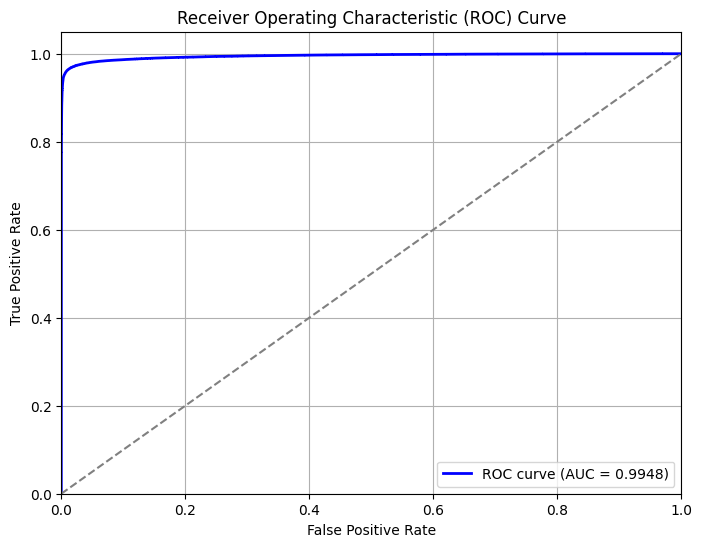

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()